# **Week 5: Feature Selection and Regularization on the Ames Housing Dataset**

In this homework, we will experiment with two feature selection methods and one regularization technique for linear regression:
- **Forward Selection**
- **Backward Selection**
- **Ridge Regression**

We will apply these techniques to the preprocessed Ames Housing dataset from last week, evaluate which method achieves the best cross-validation (CV) score, and provide a final test score for the best model. 

There are 4 problems with 8 graded answers worth 6 points each, and you get 2 points free. 

In [58]:
# Useful imports

import os
import kagglehub
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import requests
import io
import zipfile

from sklearn.model_selection   import train_test_split, cross_val_score,RepeatedKFold
from sklearn.linear_model      import LinearRegression,Ridge,Lasso
from sklearn.model_selection   import GridSearchCV
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.metrics           import mean_squared_error, r2_score
from sklearn.preprocessing     import StandardScaler 

random_seed = 42

## **Prelude: Download the Preprocessed Ames Housing Dataset**

I have stored the dataset as a zipped directory containing the following four files from an 80%-20% split of the Ames dataset after preprocessing (as done in the last homework):

- `X_train.csv`         
- `y_train.csv`
- `X_test.csv`          
- `y_test.csv`

**TODO:** Run the following cell to download and extract the dataset into the current working directory of this notebook.  
Alternatively, you can manually download the zip file from the provided URL, extract it, and place the files in the same directory as your notebook.

> ⚠️ **Important:**  
> DO NOT use your own version of these datasets from the last homework. The autograder expects the exact split provided in my files for both training and testing sets. Using any other split will result in incorrect results during grading.


In [59]:
# Download the Ames Housing Dataset from Snyder's web site

# URL to the zip file
zip_url = "https://www.cs.bu.edu/fac/snyder/cs505/Data/ames_housing.zip"

try:
    response = requests.get(zip_url)
    response.raise_for_status()  # Raise an error for bad status codes
    with zipfile.ZipFile(io.BytesIO(response.content)) as zipf:
        #zipf.extractall("Ames_Dataset_HW")
        zipf.extractall("ames_data")
    print("Files downloaded and extracted successfully.")
except requests.exceptions.RequestException as e:
    print(f"Error downloading the file: {e}")

# Load the datasets
X_train = pd.read_csv("ames_data/X_train.csv")
X_test = pd.read_csv("ames_data/X_test.csv")
y_train = pd.read_csv("ames_data/y_train.csv").squeeze("columns")          # converted to a Series
y_test = pd.read_csv("ames_data/y_test.csv").squeeze("columns")

print("Training and testing datasets loaded successfully.")


Files downloaded and extracted successfully.
Training and testing datasets loaded successfully.


## **Problem One: Forward Selection with the Ames Dataset**

For our first experiment we will apply the forward feature selection algorithm to the dataset. Follow these steps, using the notebook from this week's video lesson as a resource as necessary. 

**If you have not looked at the video yet, please do it now before continuing.**

**Steps to Follow:**
1. **Observe** that we have provided the `forward_feature_selection` algorithm from the video notebook for you to use. 

2. **Copy** from the video notebook into the cell indicated below the code that runs forward feature selection and generates a plot (excluding the part that prints the test MSE--we'll do that at the end of this homework). Or write your own version!

3. **Modify** this code to display the **Root Mean Squared Error (RMSE)** instead of MSE.  
   - *Remember*: RMSE is the square root of MSE, which provides results in dollars rather than dollars squared, making the metric more interpretable.  
   - Both the plot of RMSE vs. the number of selected features and the printout of the Best CV Score should use RMSE.

4. **Run** the code on `X_train` and `y_train` (keeping all default settings) to:
   - Generate the plot of **Root Mean Squared Error (RMSE)** vs. **Features Added**, and  
   - Print the **Best Feature Set** found and the **Best CV RMSE Score**.

**Hints:**
- The feature names will be more legible if you increase the size of the plot and change the angle and size of the xticks, e.g.,

        plt.xticks(range(1, len(selected_features_forward) + 1), selected_features_forward, rotation=60, ha='right', fontsize=6) 

- You may wish to change the scale of the y-axis to better see the behavior around the minimum point.

In [60]:
# Forward Feature Selection

def forward_feature_selection(X, y, model, 
                              scoring='neg_mean_squared_error', 
                              cv = 5, 
                              tol=None,               # None = no delta cutoff
                                                      # use 0.0 for "no further improvements"
                                                      # and 1e-4 for "point of diminishing returns"                                      
                              max_features=None,      # None = use all features
                              n_jobs=-1,
                              verbose=False
                             ):
    selected_features = []                            # List to store the order of features selected
    remaining_features = list(X.columns)              # Features not yet selected
    best_scores = []                                  # List to store the CV score after each feature addition
    previous_score = float('inf')                     # Initialize previous score for improvement comparison

    # Track the best subset of features and its corresponding score
    
    best_feature_set = None                           # Best combination of features found so far
    best_score = float('inf')                         # Best CV score observed so far
    
    while remaining_features:
        scores = {}                                   # Dictionary to hold CV scores for each candidate feature
        for feature in remaining_features:
            current_features = selected_features + [feature]
            
            # Compute the CV score for the current set of features (negated MSE, so lower is better)
            cv_score = -cross_val_score(model, X[current_features], y, 
                                        scoring=scoring, cv=cv, n_jobs=n_jobs
                                       ).mean()
            scores[feature] = cv_score

        # Select the feature that minimizes the CV score
        best_feature = min(scores, key=scores.get)
        current_score = scores[best_feature]
            
        # Check if the improvement is significant based on the tolerance (tol)
        if tol is not None and previous_score - current_score < tol:
            if verbose:
                print("Stopping early due to minimal improvement.")
            break

        # Add the best feature to the selected list and update score trackers
        selected_features.append(best_feature)
        best_scores.append(current_score)
        remaining_features.remove(best_feature)
        previous_score = current_score

        if verbose:
            print(f"\nFeatures: {selected_features[-3:]}, CV Score (MSE): {current_score:.4f}")
        
        # Update the best subset if the current score is better than the best so far
        if current_score < best_score:
            best_score = current_score
            best_feature_set = selected_features.copy()
        
        # Check if the maximum number of features has been reached
        if max_features is not None and len(selected_features) >= max_features:
            break

    return (
        selected_features,      # List of features in the order they were selected (this will be ALL features if max_features == None
        best_scores,            # List of cross-validation scores corresponding to each addition in the previous list
        best_feature_set,       # The subset of features that achieved the best CV score.
        best_score              # The best CV score
    )

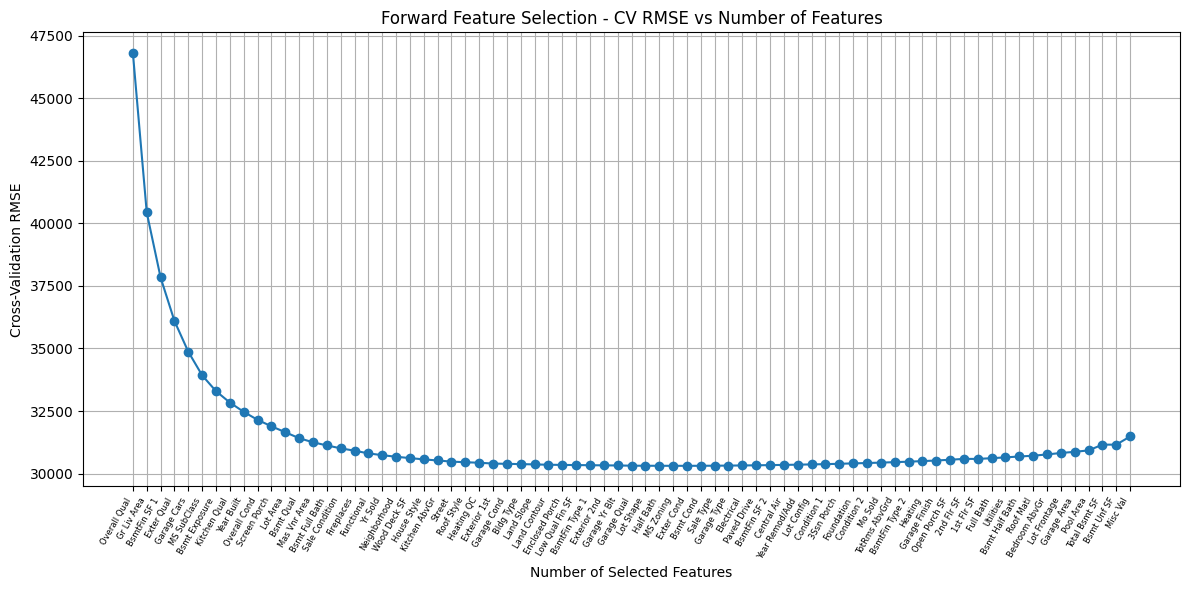

Best Feature Set:
['Overall Qual', 'Gr Liv Area', 'BsmtFin SF 1', 'Exter Qual', 'Garage Cars', 'MS SubClass', 'Bsmt Exposure', 'Kitchen Qual', 'Year Built', 'Overall Cond', 'Screen Porch', 'Lot Area', 'Bsmt Qual', 'Mas Vnr Area', 'Bsmt Full Bath', 'Sale Condition', 'Fireplaces', 'Functional', 'Yr Sold', 'Neighborhood', 'Wood Deck SF', 'House Style', 'Kitchen AbvGr', 'Street', 'Roof Style', 'Heating QC', 'Exterior 1st', 'Garage Cond', 'Bldg Type', 'Land Slope', 'Land Contour', 'Enclosed Porch', 'Low Qual Fin SF', 'BsmtFin Type 1', 'Exterior 2nd', 'Garage Yr Blt', 'Garage Qual', 'Lot Shape', 'Half Bath', 'MS Zoning', 'Exter Cond']

Best CV RMSE Score: 30312.70


In [61]:
# Your code here:  Run Forward Feature Selection, plot the results, and print out the Best Feature Set and the Best CV Score found. 

# === Run Forward Selection ===
model = LinearRegression()
selected_features_forward, best_scores_forward, best_feature_set_forward, best_score_forward = forward_feature_selection(
    X_train, y_train, model
)

# === Convert MSE to RMSE for Plotting ===
rmse_scores = np.sqrt(best_scores_forward)

# === Plot ===
plt.figure(figsize=(12, 6))
plt.plot(range(1, len(rmse_scores) + 1), rmse_scores, marker='o')
plt.xticks(ticks=range(1, len(selected_features_forward) + 1), 
           labels=selected_features_forward, 
           rotation=60, ha='right', fontsize=6)
plt.xlabel("Number of Selected Features")
plt.ylabel("Cross-Validation RMSE")
plt.title("Forward Feature Selection - CV RMSE vs Number of Features")
plt.grid(True)
plt.tight_layout()
plt.show()

# === Print Results ===
print("Best Feature Set:")
print(best_feature_set_forward)
print(f"\nBest CV RMSE Score: {np.sqrt(best_score_forward):.2f}")

### Problem One Graded Questions

Assign `a1a` to the number of features in the best feature set found

In [62]:
# Your answer here; use an expression, not a constant derived by examining the data

a1a = len(best_feature_set_forward)              # replace 0 with an expression

In [63]:
# Do not change this cell in any way

print(f"a1a = {a1a}")

a1a = 41


Assign `a1b` to the best CV RMSE score found.

In [64]:
# Your answer here; use an expression, not a constant derived by examining the data

a1b = np.sqrt(best_score_forward)                 # replace 0 with an expression

In [65]:
# Do not change this cell in any way

print(f"a1b = ${a1b:,.2f}")

a1b = $30,312.70


## **Problem Two: Backward Selection with the Ames Dataset**

Now, repeat the same process as in Problem One, but using the `backward_feature_selection` algorithm from this week’s video notebook. Again, we will use 5-Fold CV scoring. 

**Steps to Follow:**
1. **Observe** that we have provided the `backward_feature_selection` algorithm from this week's video notebook for you to use.
2. **Run** the backward selection algorithm on the Ames dataset (`X_train` and `y_train`).
3. **Plot** the results: Display the Root Mean Squared Error (RMSE) vs. the features removed by the algorithm.
4. **Print** the Best Feature Set found by backward selection and the corresponding best CV RMSE Score.


In [66]:
# Backward Feature Selection

def backward_feature_selection(X, y, model, 
                               scoring='neg_mean_squared_error', 
                               cv = 5, 
                               tol=None,               # None = no delta cutoff
                                                       # use 0.0 for "no further improvements"
                                                       # and 1e-4 for "point of diminishing returns"                                      
                               max_features=None,      # If None, remove features until only 1 remains
                                                       # Otherwise, stop when this many features remain
                               n_jobs=-1,
                               verbose=True
                              ):
    
    # Helper function to compute CV score using LinearRegression
    def cv_score(features):
        return -cross_val_score(model, X[features], y, 
                                scoring=scoring, cv=cv, 
                                n_jobs=n_jobs          ).mean()
    
    # Start with all features (using a list for easier manipulation)
    features_remaining = list(X.columns)
    
    # Compute initial CV score with the full feature set
    initial_score = cv_score(features_remaining)
    
    # Initialize tracking variables
    best_score        = initial_score                # Best (lowest) CV score observed so far
    best_feature_set  = features_remaining.copy()    # Feature set corresponding to best_score
    selected_features = ['NONE']                     # List to record the order in which features are removed
    best_scores       = [initial_score]              # List to record the CV score after each removal (starting with full set)
    
    if verbose:
        print("Start with full set of features:")
        print(f'{features_remaining}  CV score (MSE): {np.around(initial_score, 4)}\n')
    
    # Determine the target number of features to keep:
    # For backward elimination, if max_features is None, we remove until 1 feature remains.
    target_feature_count = 1 if max_features is None else max_features
    
    prev_score = initial_score
    round_num = 1
    # Continue removing features until we reach the target count
    while len(features_remaining) > target_feature_count:
        if verbose:
            print(f'Round {round_num}:')
            
        # Initialize variables to track the best removal in this round
        lowest_score = float('inf')
        feature_to_remove = None
        best_new_features = None
        
        # Try removing each feature one at a time
        for feature in features_remaining:
            new_feature_set = features_remaining.copy()
            new_feature_set.remove(feature)
            new_score = cv_score(new_feature_set)
            if verbose:
                print('Trying removal of:',feature, np.around(new_score, 4))
            if new_score < lowest_score:
                lowest_score = new_score
                feature_to_remove = feature
                best_new_features = new_feature_set
        
        # Check if improvement is significant enough (if tol is set)
        if tol is not None and (prev_score - lowest_score) < tol:
            if verbose:
                print("\nStopping early due to minimal improvement.")
            break
        
        # Update the best score and feature set if current removal improves performance
        if lowest_score < best_score:
            best_score = lowest_score
            best_feature_set = best_new_features.copy()
        
        # Update trackers for this round
        prev_score = lowest_score
        features_remaining = best_new_features
        selected_features.append(feature_to_remove)
        best_scores.append(lowest_score)
        
        if verbose:
            print(f'\nRemoving {feature_to_remove}:  CV score (MSE) {np.around(lowest_score, 4)}\n')
        round_num += 1

    return (
        selected_features,      # Order in which features were removed
        best_scores,            # CV scores after each removal step
        best_feature_set,       # Feature set that achieved the best CV score
        best_score              # Best (lowest) CV score
    )


Start with full set of features:
['MS SubClass', 'MS Zoning', 'Lot Frontage', 'Lot Area', 'Street', 'Lot Shape', 'Land Contour', 'Utilities', 'Lot Config', 'Land Slope', 'Neighborhood', 'Condition 1', 'Condition 2', 'Bldg Type', 'House Style', 'Overall Qual', 'Overall Cond', 'Year Built', 'Year Remod/Add', 'Roof Style', 'Roof Matl', 'Exterior 1st', 'Exterior 2nd', 'Mas Vnr Area', 'Exter Qual', 'Exter Cond', 'Foundation', 'Bsmt Qual', 'Bsmt Cond', 'Bsmt Exposure', 'BsmtFin Type 1', 'BsmtFin SF 1', 'BsmtFin Type 2', 'BsmtFin SF 2', 'Bsmt Unf SF', 'Total Bsmt SF', 'Heating', 'Heating QC', 'Central Air', 'Electrical', '1st Flr SF', '2nd Flr SF', 'Low Qual Fin SF', 'Gr Liv Area', 'Bsmt Full Bath', 'Bsmt Half Bath', 'Full Bath', 'Half Bath', 'Bedroom AbvGr', 'Kitchen AbvGr', 'Kitchen Qual', 'TotRms AbvGrd', 'Functional', 'Fireplaces', 'Garage Type', 'Garage Yr Blt', 'Garage Finish', 'Garage Cars', 'Garage Area', 'Garage Qual', 'Garage Cond', 'Paved Drive', 'Wood Deck SF', 'Open Porch SF', 'E

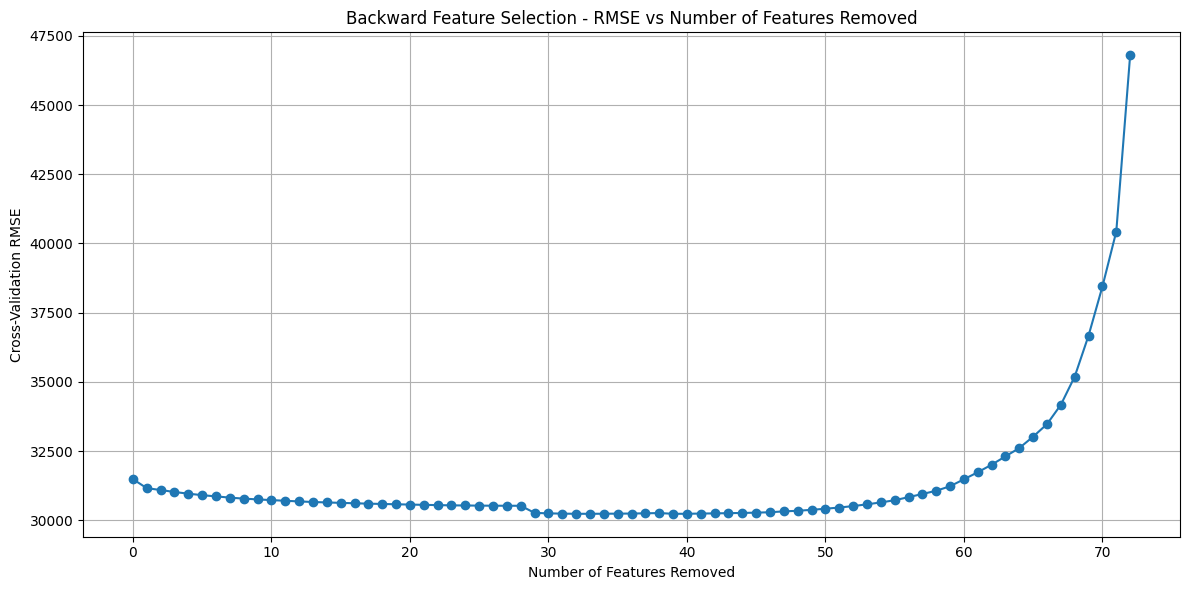

Best Feature Set (Remaining):
['MS SubClass', 'Lot Area', 'Street', 'Land Contour', 'Land Slope', 'Neighborhood', 'Bldg Type', 'House Style', 'Overall Qual', 'Overall Cond', 'Year Built', 'Roof Style', 'Exterior 1st', 'Mas Vnr Area', 'Exter Qual', 'Bsmt Qual', 'Bsmt Exposure', 'BsmtFin Type 1', 'Bsmt Unf SF', 'Heating QC', 'Gr Liv Area', 'Bsmt Full Bath', 'Kitchen AbvGr', 'Kitchen Qual', 'Functional', 'Fireplaces', 'Garage Yr Blt', 'Garage Cars', 'Garage Qual', 'Garage Cond', 'Wood Deck SF', 'Screen Porch', 'Yr Sold', 'Sale Condition']

Best CV RMSE Score: 30232.47


In [67]:
# Your code here:  Run Backward Feature Selection, plot the results, and print out the Best Feature Set and the Best CV RMSE Score found. 
# Run backward slection

model = LinearRegression()
selected_features_backward, best_scores_backward, best_feature_set_backward, best_score_backward = backward_feature_selection(
    X_train, y_train, model, verbose=True
)

# Convert MSE to RMSE
rmse_scores_backward = np.sqrt(best_scores_backward)

# Plot RMSE vs. number of features removed
plt.figure(figsize=(12, 6))
plt.plot(range(len(rmse_scores_backward)), rmse_scores_backward, marker='o')
plt.xlabel("Number of Features Removed")
plt.ylabel("Cross-Validation RMSE")
plt.title("Backward Feature Selection - RMSE vs Number of Features Removed")
plt.grid(True)
plt.tight_layout()
plt.show()

# Print results
print("Best Feature Set (Remaining):")
print(best_feature_set_backward)
print(f"\nBest CV RMSE Score: {np.sqrt(best_score_backward):.2f}")

### Problem Two Graded Questions

Assign `a2a` to the number of features in the best feature set found

In [68]:
# Your answer here; use an expression, not a constant derived by examining the data

a2a = len(best_feature_set_backward)                # replace 0 with an expression

In [69]:
# Do not change this cell in any way

print(f"a2a = {a2a}")

a2a = 34


Assign `a2b` to the best CV RMSE score found.

In [70]:
# Your answer here; use an expression, not a constant derived by examining the data

a2b = np.sqrt(best_score_backward)                   # replace 0 with an expression

In [71]:
# Do not change this cell in any way

print(f"a2b = ${a2b:,.2f}")

a2b = $30,232.47


## **Problem Three: Ridge Regression on the Ames Housing Dataset**

In this problem, we will apply Ridge Regression to the Ames Housing dataset. Ridge Regression includes a hyperparameter $\alpha$ that controls the strength of the regularization penalty, which helps prevent overfitting by constraining the growth of the model’s coefficients. A higher $\alpha$ penalizes large coefficients more, while a lower $\alpha$ allows them to grow larger.

When creating the model, the parameter must be specified, for example:

```python
ridge_model = Ridge(alpha=100)
```

This introduces another instance of the model selection problem: we must determine the value of $\alpha$ that yields the best CV RMSE score.

**Steps to Follow:**

1. **Standardize the Data:**  
   Ridge regression is sensitive to the scale of the features, so we will use `StandardScaler` to standardize the feature set to have a mean of 0 and a standard deviation of 1 before training and testing. Note that the target variable does **not** need to be scaled.

2. **Perform Cross-Validation Over a Range of Alpha Values:**  
   For each $\alpha \in \{100, 110, 120, \dots, 500\}$, calculate the cross-validation RMSE score for the model using 5-Fold CV scoring.  

3. **Visualize the Results:**  
   Plot the CV RMSE scores against the $\alpha$ values.

4. **Identify the Best Alpha:**  
   Determine the $\alpha$ that results in the minimum CV RMSE Score and print it out, along with the score.

**Tip:** It would be an *excellent* idea to add the suffix `_scaled` to any set to which you apply scaling.

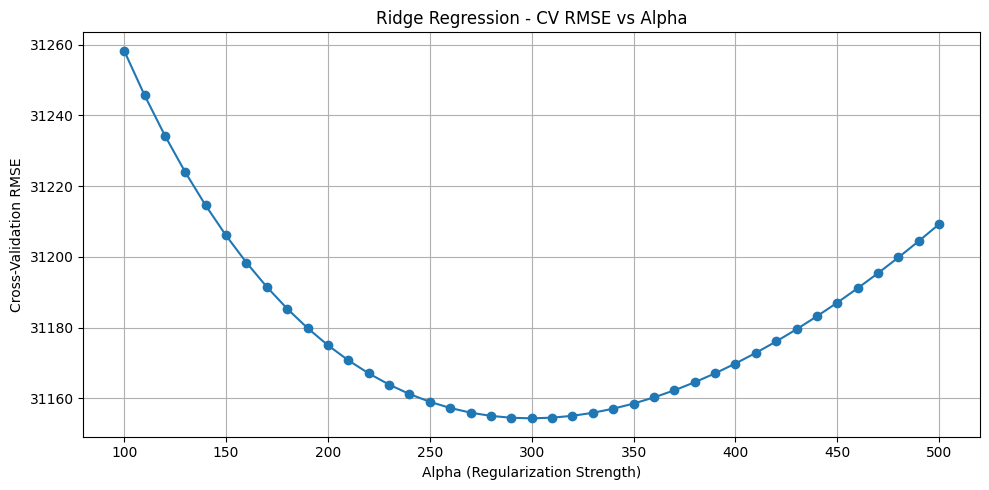

Best Alpha: 300
Best CV RMSE Score: 31154.32


In [72]:
# Your code here
# Standardize X_train only (not y_train)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)

# === Step 2: Cross-Validation over a Range of Alpha Values ===
alphas = list(range(100, 501, 10))  # [100, 110, ..., 500]
cv_rmse_scores = []

for alpha in alphas:
    ridge_model = Ridge(alpha=alpha)
    neg_mse = cross_val_score(ridge_model, X_train_scaled, y_train, 
                              scoring='neg_mean_squared_error', cv=5)
    rmse = np.sqrt(-neg_mse.mean())
    cv_rmse_scores.append(rmse)

# === Step 3: Plot CV RMSE vs Alpha ===
plt.figure(figsize=(10, 5))
plt.plot(alphas, cv_rmse_scores, marker='o')
plt.xlabel("Alpha (Regularization Strength)")
plt.ylabel("Cross-Validation RMSE")
plt.title("Ridge Regression - CV RMSE vs Alpha")
plt.grid(True)
plt.tight_layout()
plt.show()

# === Step 4: Identify the Best Alpha and RMSE ===
best_alpha = alphas[np.argmin(cv_rmse_scores)]
best_rmse = min(cv_rmse_scores)

print(f"Best Alpha: {best_alpha}")
print(f"Best CV RMSE Score: {best_rmse:.2f}")

### Problem Three Graded Answers

Set a3a to the alpha determined to have the minimum CV RMSE score.

In [73]:
# Your answer here; use an expression, not a constant derived by examining the data

a3a =  alphas[np.argmin(cv_rmse_scores)]                   # replace 0 with an expression

In [74]:
# Do not change this cell in any way. 

print(f"a3a = {a3a}")

a3a = 300


Set `a3b` to the CV score found at that alpha. 

In [75]:
# Your answer here; use an expression, not a constant derived by examining the data

a3b = min(cv_rmse_scores)                     # replace 0 with an expression

In [76]:
# Do not change this cell in any way. 

print(f"a3b = ${a3b:,.2f}")

a3b = $31,154.32


## **Problem Four: Evaluate Your Best Model**

In this final problem, you will identify the model with the best cross-validation RMSE score and evaluate its performance on the held-out test set.

#### **Steps to Follow:**

1. **Identify the Best Model:**
   From your previous results, select the model that achieved the lowest CV RMSE score. 

3. **Train and Test the Selected Model:** 
   - For Forward or Backward Feature Selection:  Train a Linear Regression model using `X_train` **restricted to the selected best feature set**, and evaluate it on `X_test` restricted to the same feature set.
   - For Ridge Regression:   Train a Ridge Regression model using the best alpha found from cross-validation, with `StandardScaler` applied to both `X_train` and `X_test` before training and testing.

4. **Report Your Results:**
   Print the name of the best model and the test RMSE in dollars.



In [77]:
# Your code here
# Determine best model by comparing CV RMSE scores
cv_scores = {'Forward': a1b, 'Backward': a2b, 'Ridge': a3b}
best_model_name = min(cv_scores, key=cv_scores.get)

# Train and evaluate the best model
if best_model_name == 'Forward':
    model = LinearRegression()
    model.fit(X_train[best_feature_set_forward], y_train)
    y_pred = model.predict(X_test[best_feature_set_forward])
elif best_model_name == 'Backward':
    model = LinearRegression()
    model.fit(X_train[best_feature_set_backward], y_train)
    y_pred = model.predict(X_test[best_feature_set_backward])
elif best_model_name == 'Ridge':
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    model = Ridge(alpha=a3a)
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)

# Compute RMSE on test set
test_rmse = np.sqrt(mean_squared_error(y_test, y_pred))

# Print results
print(f"Best Model Based on CV: {best_model_name}")
print(f"Test RMSE: ${test_rmse:.2f}")

Best Model Based on CV: Backward
Test RMSE: $33731.86


### Problem Four Graded Answers

Set `a4a` to the best model, according to the CV RMSE score.

In [78]:
# Your answer here

a4a = 2                   # replace 0 with one of [1,2,3]

In [79]:
# Do not change this cell in any way. 

print(f"a4a = {a4a}")

a4a = 2


Set `a4b` to the test RMSE for the best model.

In [80]:
# Your answer here; use an expression, not a constant derived by examining the data

a4b = np.sqrt(mean_squared_error(y_test, y_pred))                  # replace 0 with an expression

In [81]:
# Do not change this cell in any way. 

print(f"a4b = ${a4b:,.2f}")

a4b = $33,731.86


### Final question...

Why didn't we evaluate *all* the models on the test set and compare them?

### Some answers...

It’s tempting to reconsider your choice based on test scores, but this violates the core principle of not "training to the test." That’s why we deliberately avoided evaluating all models on the test set.

The test set doesn’t influence model training; it serves as a final, unbiased check on how well your chosen model generalizes to unseen data, ensuring that your selection process wasn’t overly optimistic.

A natural **next question** is: Why use a test set at all? Beyond being an industry-standard practice that simulates the real world—where you can’t adjust your model after deployment—consider:

- **Validating your workflow:** A strong test score confirms that your model selection process (feature selection, hyperparameter tuning, etc.) was sound. A poor test score despite good cross-validation results may indicate overfitting or a flawed approach.
  
- **Guarding against over-optimism:** Cross-validation can be slightly optimistic, especially with limited data or repeated trials. The test set provides a final safeguard against relying on an overly tuned model.


Final Answers:
We didn't evaluate all models on the test set because that would compromise the independence of the test set, which is meant to simulate real-world, unseen data.

The test set is not part of model selection — it's only used after model selection (via cross-validation) is complete.

If we evaluated all models on the test set and chose the best one after seeing test results, we'd effectively be training to the test, which leads to:

Overfitting to a dataset meant to represent generalization, Overestimating model performance, Invalid conclusions, especially when deployed in real-world settings.

To answer why Use a Test Set at All?
It validates our entire pipeline, from preprocessing to model selection.
It gives a final, unbiased estimate of model performance.
It helps us to detect overfitting that cross-validation might miss.
In industry, it's our best approximation of real-world performance before deploying the model.